In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Set, Dict
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# RDKit
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import DataStructs

# Scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr

/home/alonso/.local/lib/python3.12/site-packages/pandas/core/computation/expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.9.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/alonso/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
sd = pd.read_csv("../data/SD.csv")
qm7 = pd.read_csv("../data/qm7.csv")
lipo = pd.read_csv("../data/Lipophilicity.csv")

In [3]:
# Implement molecule standardization
def standardize_smiles(smiles: str):
    """Standardize a SMILES string.
    
    Steps:
    1. Parse SMILES to RDKit Mol
    2. Remove salts (keep largest fragment)
    3. Neutralize charges where chemically appropriate
    4. Return canonical SMILES (preserving stereochemistry)
    
    Args:
        smiles: Input SMILES string
        
    Returns:
        canonical_smiles or None if failed
    """

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Remove salts
    lfc = rdMolStandardize.LargestFragmentChooser()
    mol = lfc.choose(mol)

    # Neutralize charges
    uncharger = rdMolStandardize.Uncharger()
    mol = uncharger.uncharge(mol)

    # Standardize tautomers
    te = rdMolStandardize.TautomerEnumerator()
    mol = te.Canonicalize(mol)

    return Chem.MolToSmiles(mol)


In [4]:
# Apply standardization to all molecules
print("Standardizing molecules...")

# Note: This produces quite a bit of output, which you can suppress as follows
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  # Disable all RDKit logging

standardized_data = []
failed_indices = []

for idx, row in sd.iterrows():
    std_smiles = standardize_smiles(row['neut-smiles'])
    
    if std_smiles is not None:
        standardized_data.append({
            'neut-smiles': std_smiles,
            'original_smiles': row['neut-smiles'],
            'XC50': row['XC50'],
            'mol': Chem.MolFromSmiles(std_smiles)
        })
    else:
        failed_indices.append(idx)

sd_std = pd.DataFrame(standardized_data)

print(f"\nStandardization results:")
print(f"  Original: {len(sd)} molecules")
print(f"  Standardized: {len(sd_std)} molecules")
print(f"  Failed: {len(failed_indices)} molecules")

Standardizing molecules...

Standardization results:
  Original: 319081 molecules
  Standardized: 319081 molecules
  Failed: 0 molecules


In [5]:
# Apply standardization to all molecules
print("Standardizing molecules...")

# Note: This produces quite a bit of output, which you can suppress as follows
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  # Disable all RDKit logging

standardized_data = []
failed_indices = []

for idx, row in qm7.iterrows():
    std_smiles = standardize_smiles(row['smiles'])
    
    if std_smiles is not None:
        standardized_data.append({
            'smiles': std_smiles,
            'original_smiles': row['smiles'],
            'u0_atom': row['u0_atom'],
            'mol': Chem.MolFromSmiles(std_smiles)
        })
    else:
        failed_indices.append(idx)

qm7_std = pd.DataFrame(standardized_data)

print(f"\nStandardization results:")
print(f"  Original: {len(qm7)} molecules")
print(f"  Standardized: {len(qm7_std)} molecules")
print(f"  Failed: {len(failed_indices)} molecules")

Standardizing molecules...

Standardization results:
  Original: 6834 molecules
  Standardized: 6834 molecules
  Failed: 0 molecules


In [6]:
# Apply standardization to all molecules
print("Standardizing molecules...")

# Note: This produces quite a bit of output, which you can suppress as follows
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  # Disable all RDKit logging

standardized_data = []
failed_indices = []

for idx, row in lipo.iterrows():
    std_smiles = standardize_smiles(row['smiles'])
    
    if std_smiles is not None:
        standardized_data.append({
            'smiles': std_smiles,
            'original_smiles': row['smiles'],
            'exp': row['exp'],
            'mol': Chem.MolFromSmiles(std_smiles)
        })
    else:
        failed_indices.append(idx)

lipo_std = pd.DataFrame(standardized_data)

print(f"\nStandardization results:")
print(f"  Original: {len(lipo)} molecules")
print(f"  Standardized: {len(lipo_std)} molecules")
print(f"  Failed: {len(failed_indices)} molecules")

Standardizing molecules...

Standardization results:
  Original: 4200 molecules
  Standardized: 4200 molecules
  Failed: 0 molecules


In [7]:
sd_std['XC50'].isna().sum()

318179

Duplicate SMILES after standardization: 75

Found 74 unique SMILES that appear multiple times:

  SMILES: Cc1[nH]n(-c2ccccc2)c(=O)c1-c1ccccc1
  XC50 values: [nan, nan]

  SMILES: Cc1ccc(C2C3=C(CC(C)(C)CC3=O)N=C3c4ccccc4C(=O)C32)cc1
  XC50 values: [nan, nan]

  SMILES: CC1(C)C=C2N=C3c4ccccc4C(=O)C3C(c3ccc(Cl)cc3)C2C(=O)C1
  XC50 values: [nan, nan]

  SMILES: N=C1C(=O)NC(=O)C1c1ccccc1
  XC50 values: [nan, nan]

  SMILES: CCOC(=O)c1cc(CC)sc1N=Cc1c(O)[nH]c(=S)[nH]c1=O
  XC50 values: [nan, nan]

  SMILES: COc1cccc(C(C2C(=O)CC(C)(C)CC2=O)C2C(=O)CC(C)(C)CC2=O)c1
  XC50 values: [nan, nan]

  SMILES: CN1CCC2(CC1)C(C#N)C(=N)NC(=S)C2C#N
  XC50 values: [nan, nan]

  SMILES: O=c1cc(-c2ccccc2)[nH]n1-c1ccc([N+](=O)[O-])cc1
  XC50 values: [nan, nan]

  SMILES: CC(=O)Nc1ccc(N=Nc2c(C)[nH]n(C(N)=S)c2=O)cc1
  XC50 values: [nan, nan]

  SMILES: CC(=O)Nc1c(O)[nH]c(SCC(=O)Nc2c(C)cccc2C)nc1=O
  XC50 values: [nan, nan]

  SMILES: COc1cc2c(cc1OC)C(CC#N)=NC(C)(C)C2
  XC50 values: [nan, nan]

  SMILES: Cc1[nH]n(C

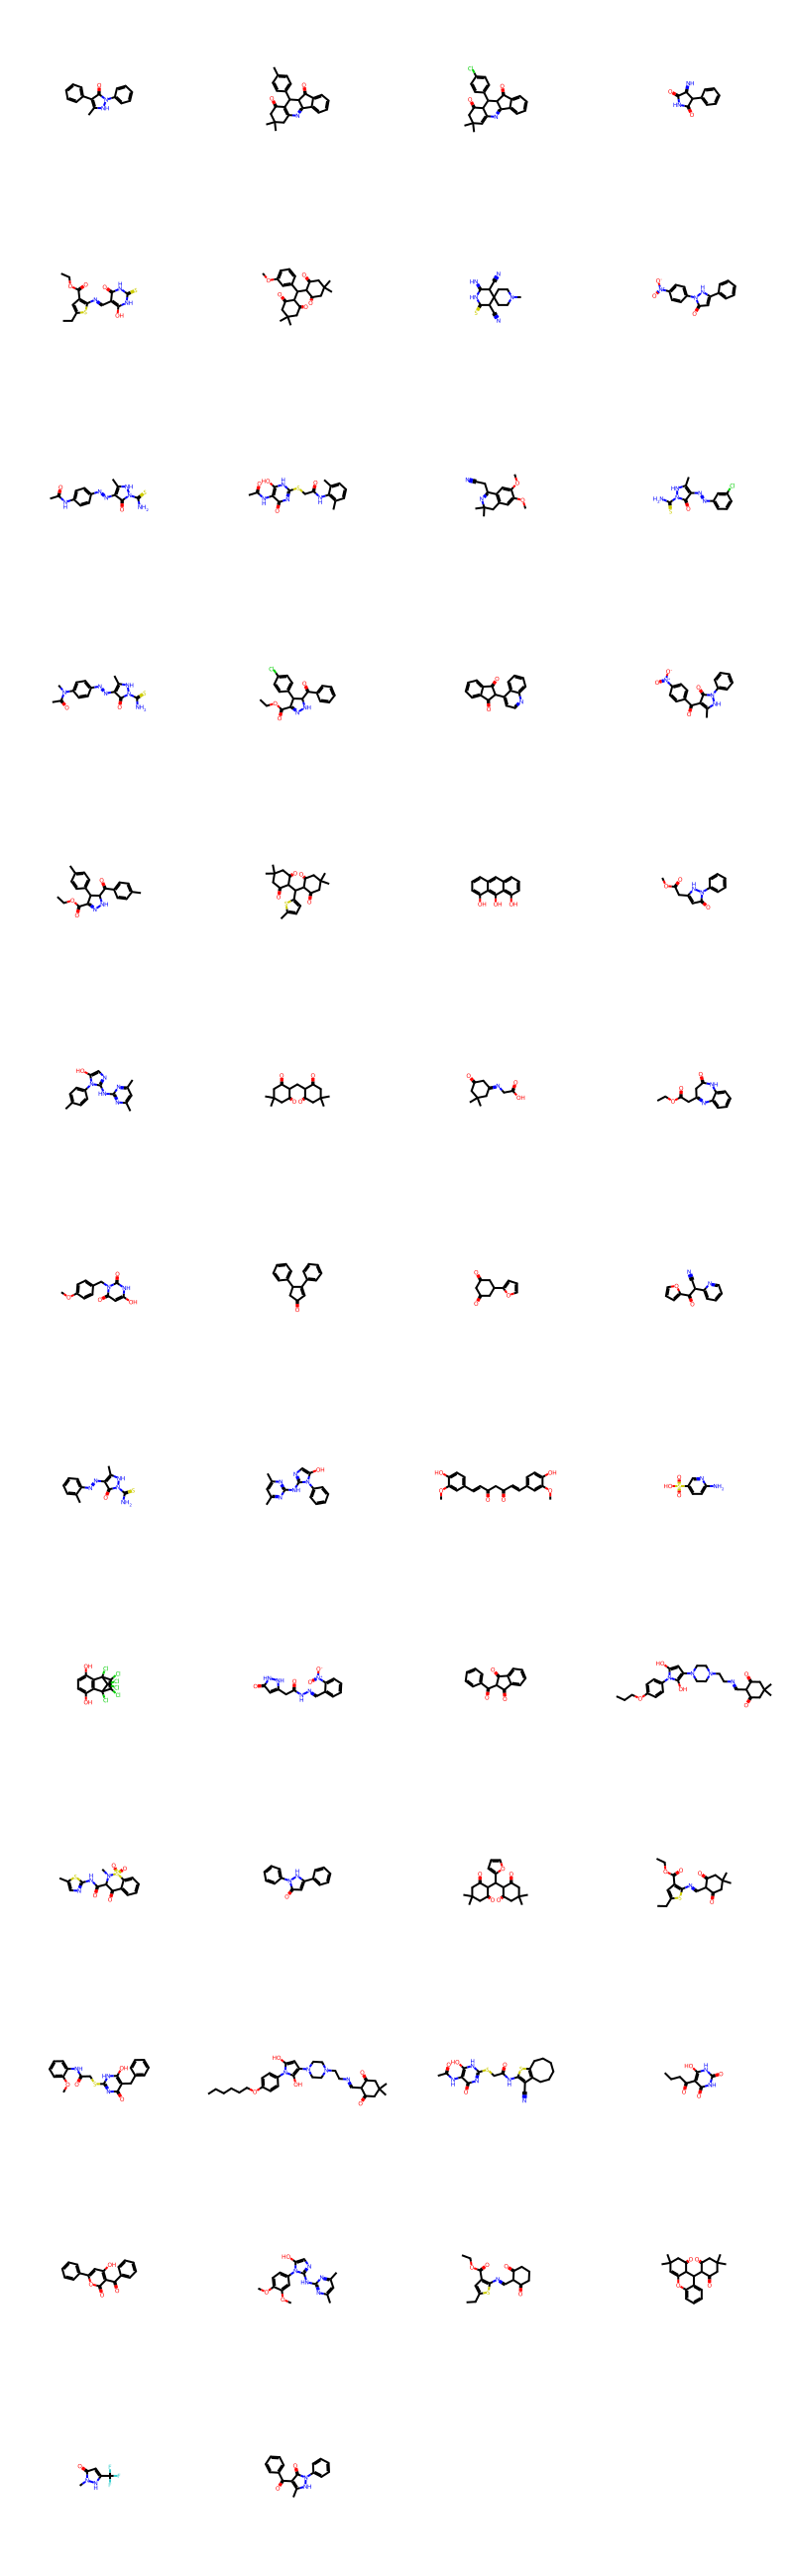

In [8]:
# Check for duplicates
n_duplicates = sd_std['neut-smiles'].duplicated().sum()
print(f"Duplicate SMILES after standardization: {n_duplicates}")

if n_duplicates > 0:
    # Show duplicates
    dup_smiles = sd_std[sd_std['neut-smiles'].duplicated(keep=False)]['neut-smiles'].unique()
    print(f"\nFound {len(dup_smiles)} unique SMILES that appear multiple times:")
    
    for smi in dup_smiles:
        dups = sd_std[sd_std['neut-smiles'] == smi]
        print(f"\n  SMILES: {smi}")
        print(f"  XC50 values: {dups['XC50'].tolist()}")
        
    # Visualize duplicates
    dup_mols = [Chem.MolFromSmiles(smi) for smi in dup_smiles]
    if dup_mols:
        img = Draw.MolsToGridImage(dup_mols, molsPerRow=4, subImgSize=(200, 200))
        display(img)

In [9]:
if n_duplicates > 0:
    sd_std = sd_std.groupby('neut-smiles').agg({
        'XC50': 'mean',              
        'mol': 'first'               
    }).reset_index()
    print(f"After deduplication: {len(sd_std)} molecules")
else:
    sd_std = sd_std.copy()
    print(f"No duplicates to remove: {len(sd_std)} molecules")

After deduplication: 319006 molecules


Duplicate SMILES after standardization: 82

Found 70 unique SMILES that appear multiple times:

  SMILES: CC=CC(C)=O
  u0_atom values: [-1433.53, -1427.01]

  SMILES: CCC(=O)CO
  u0_atom values: [-1375.33, -1369.63]

  SMILES: O=C1C=CCC1
  u0_atom values: [-1303.54, -1309.11]

  SMILES: Oc1ccco1
  u0_atom values: [-1108.37, -1115.25]

  SMILES: C=CC(=O)CO
  u0_atom values: [-1222.74, -1230.43]

  SMILES: C#CC(=O)CO
  u0_atom values: [-1058.82, -1068.2]

  SMILES: Oc1ccc[nH]1
  u0_atom values: [-1193.68, -1188.12]

  SMILES: Cn1cccc1N
  u0_atom values: [-1547.56, -1540.02]

  SMILES: CNc1ccc[nH]1
  u0_atom values: [-1537.97, -1546.86]

  SMILES: CC1=CC=CC1=O
  u0_atom values: [-1463.66, -1464.9, -1458.24]

  SMILES: CC1=CCCC1=O
  u0_atom values: [-1610.81, -1600.58, -1605.99]

  SMILES: CC1=CC(=O)CC1
  u0_atom values: [-1599.06, -1603.82, -1610.53, -1605.4]

  SMILES: Cc1ccc(O)o1
  u0_atom values: [-1408.88, -1417.93]

  SMILES: Cc1ccoc1O
  u0_atom values: [-1406.28, -1412.53]

  SMILES

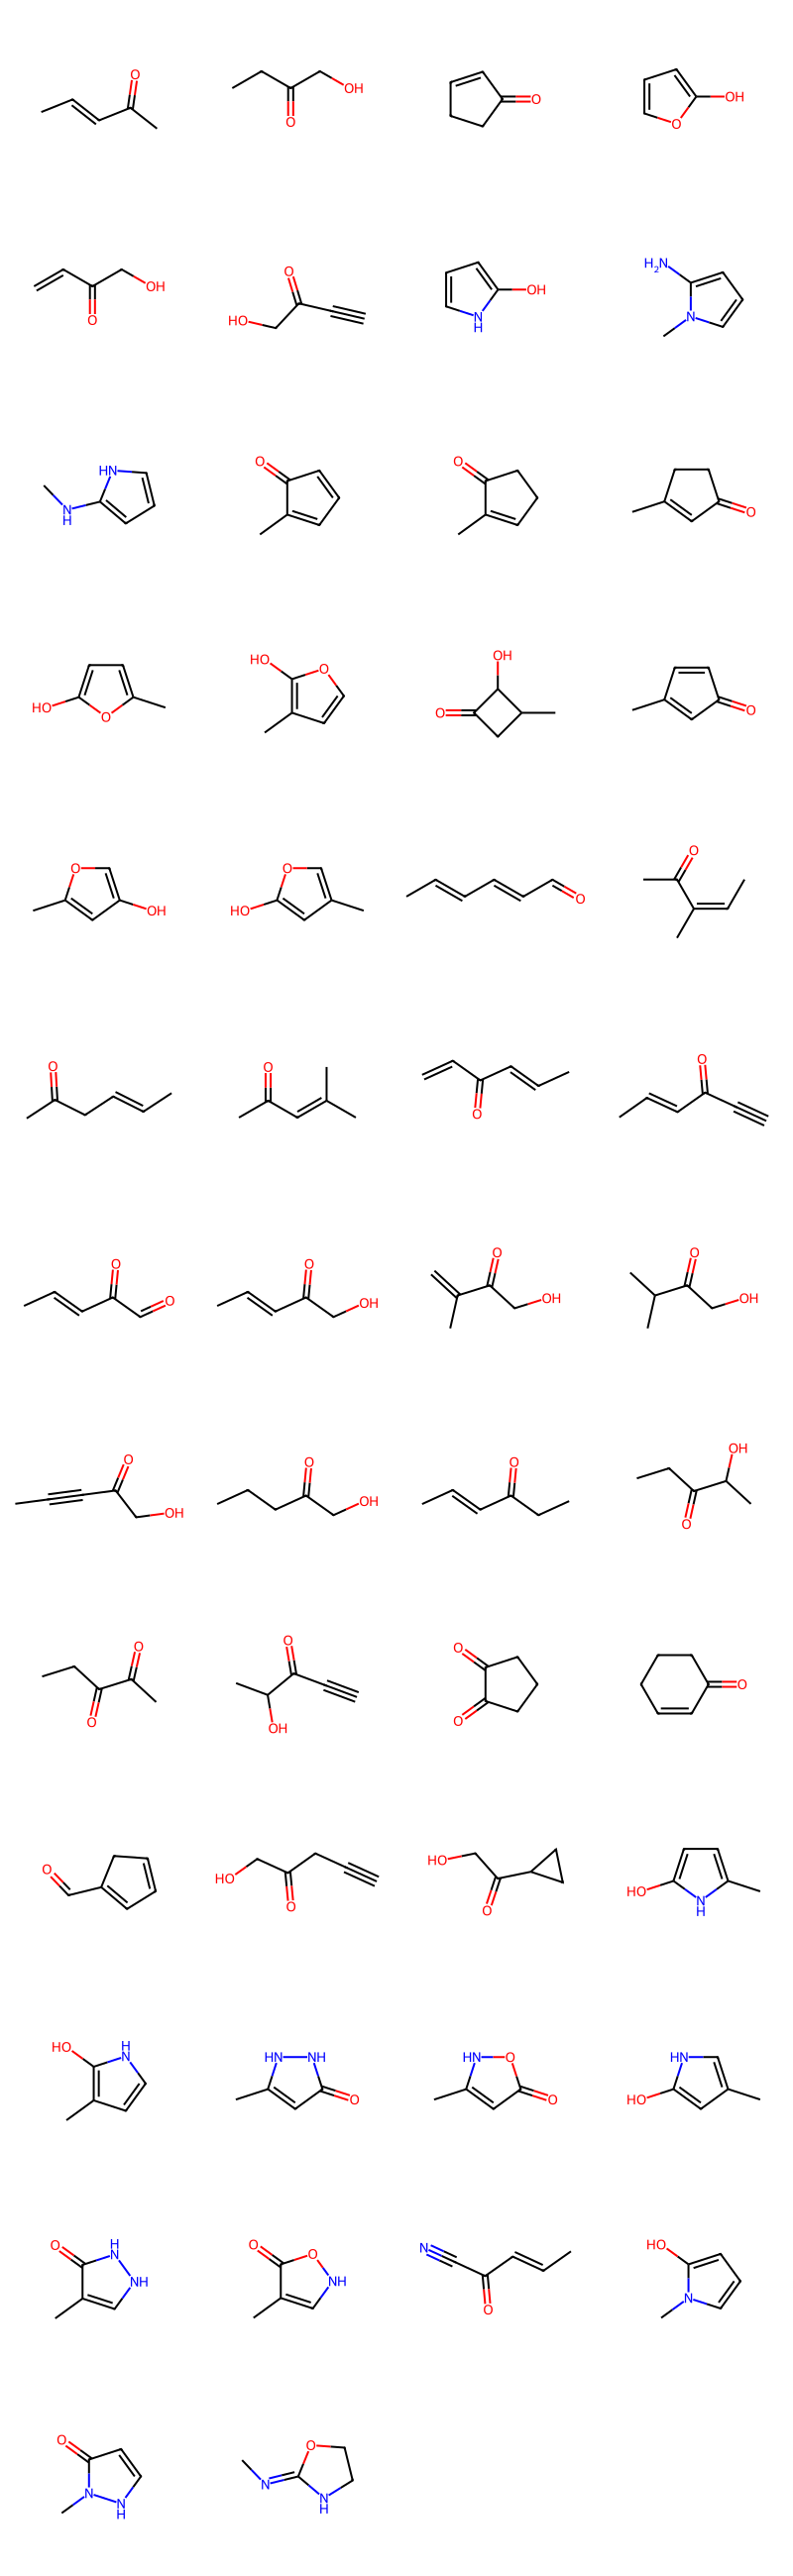

In [10]:
# Check for duplicates
n_duplicates = qm7_std['smiles'].duplicated().sum()
print(f"Duplicate SMILES after standardization: {n_duplicates}")

if n_duplicates > 0:
    # Show duplicates
    dup_smiles = qm7_std[qm7_std['smiles'].duplicated(keep=False)]['smiles'].unique()
    print(f"\nFound {len(dup_smiles)} unique SMILES that appear multiple times:")
    
    for smi in dup_smiles:
        dups = qm7_std[qm7_std['smiles'] == smi]
        print(f"\n  SMILES: {smi}")
        print(f"  u0_atom values: {dups['u0_atom'].tolist()}")
        
    # Visualize duplicates
    dup_mols = [Chem.MolFromSmiles(smi) for smi in dup_smiles]
    if dup_mols:
        img = Draw.MolsToGridImage(dup_mols, molsPerRow=4, subImgSize=(200, 200))
        display(img)

In [11]:
if n_duplicates > 0:
    qm7_std = qm7_std.groupby('smiles').agg({
        'u0_atom': 'mean',              
        'mol': 'first'               
    }).reset_index()
    print(f"After deduplication: {len(qm7_std)} molecules")
else:
    qm7_std = qm7_std.copy()
    print(f"No duplicates to remove: {len(qm7_std)} molecules")

After deduplication: 6752 molecules


Duplicate SMILES after standardization: 22

Found 19 unique SMILES that appear multiple times:

  SMILES: O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2cc(Cl)sc2[nH]1
  exp values: [3.37, 3.27, 3.3]

  SMILES: NC(Cc1c[nH]c2ccccc12)C(=O)O
  exp values: [-1.17, -0.92, -1.08]

  SMILES: Cc1nc(C)c(-c2ccc(C3CCC(CC(=O)O)CC3)c(F)c2)nc1C(N)=O
  exp values: [1.3, 1.2]

  SMILES: O=C(O)C(Cc1ccccc1)N1CCC(CN2CCC(Oc3ccc(Cl)c(Cl)c3)CC2)CC1
  exp values: [2.5, 2.5]

  SMILES: O=C(O)C(c1ccccc1)N1CCC(CN2CCC(Oc3ccc(Cl)c(Cl)c3)CC2)CC1
  exp values: [2.17, 2.14]

  SMILES: Cc1nc(C)c(-c2ccc3c(c2)CCC32CCC(C(=O)O)CC2)nc1C(N)=O
  exp values: [1.2, 1.3]

  SMILES: O=C(Nc1ncc(F)s1)C(CC1CCOCC1)c1ccc(S(=O)(=O)C2CC2)cc1
  exp values: [3.19, 3.3]

  SMILES: COc1ccc2cc(C(C)C(=O)O)ccc2c1
  exp values: [0.23, 0.13]

  SMILES: N#CC(C(=N)Sc1ccc(N)cc1)c1ccccc1C(F)(F)F
  exp values: [3.4, 3.3]

  SMILES: Cc1nc(C(=O)C(C)Oc2ccc(SCCCCCc3ccccc3)cc2)sc1CCCC(=O)O
  exp values: [2.03, 3.58]

  SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1

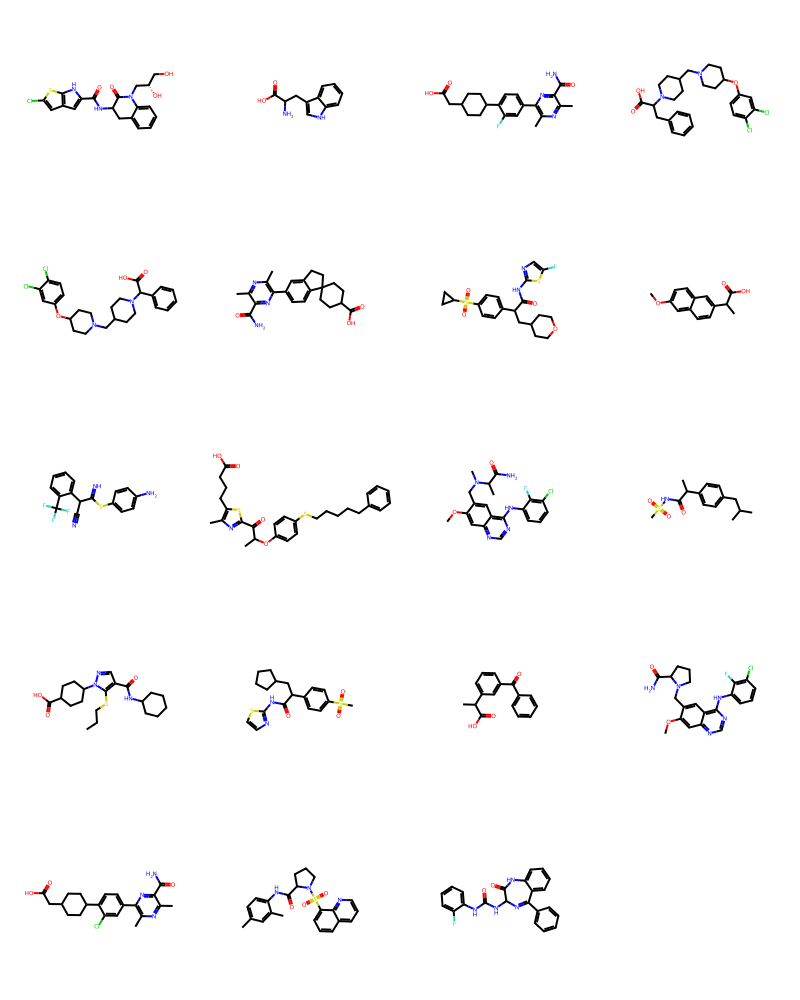

In [12]:
# Check for duplicates
n_duplicates = lipo_std['smiles'].duplicated().sum()
print(f"Duplicate SMILES after standardization: {n_duplicates}")

if n_duplicates > 0:
    # Show duplicates
    dup_smiles = lipo_std[lipo_std['smiles'].duplicated(keep=False)]['smiles'].unique()
    print(f"\nFound {len(dup_smiles)} unique SMILES that appear multiple times:")
    
    for smi in dup_smiles:
        dups = lipo_std[lipo_std['smiles'] == smi]
        print(f"\n  SMILES: {smi}")
        print(f"  exp values: {dups['exp'].tolist()}")
        
    # Visualize duplicates
    dup_mols = [Chem.MolFromSmiles(smi) for smi in dup_smiles]
    if dup_mols:
        img = Draw.MolsToGridImage(dup_mols, molsPerRow=4, subImgSize=(200, 200))
        display(img)

In [13]:
if n_duplicates > 0:
    lipo_std = lipo_std.groupby('smiles').agg({
        'exp': 'mean',              
        'mol': 'first'               
    }).reset_index()
    print(f"After deduplication: {len(lipo_std)} molecules")
else:
    lipo_std = lipo_std.copy()
    print(f"No duplicates to remove: {len(lipo_std)} molecules")

After deduplication: 4178 molecules


In [14]:
# Implement scaffold extraction
def get_scaffold(mol: Chem.Mol) -> str:
    """Extract the Murcko scaffold from a molecule.
    
    Args:
        mol: RDKit Mol object
        
    Returns:
        SMILES string of the generic scaffold, or 'ACYCLIC' for molecules without rings
    """
    try:
        # Compute the generic Murcko scaffold given a Mol object
        scaffold = Chem.Scaffolds.MurckoScaffold.GetScaffoldForMol(mol)

        # Then, turn that scaffold into a SMILES
        scaffold_smiles = Chem.MolToSmiles(scaffold, canonical=True)
        
        if scaffold_smiles == '' or scaffold.GetNumAtoms() == 0:
            return 'ACYCLIC'
        
        return scaffold_smiles
    except:
        return 'ACYCLIC'

In [15]:
# Compute scaffolds for all molecules
sd_std['scaffold'] = sd_std['mol'].apply(get_scaffold)  # This runs your function, defined above, for all Mol objects

n_scaffolds = sd_std['scaffold'].nunique()
scaffold_counts = sd_std['scaffold'].value_counts()

print(f"Number of unique scaffolds: {n_scaffolds}")
print(f"\nMost common scaffolds:")
print(scaffold_counts.head(10))

Number of unique scaffolds: 90476

Most common scaffolds:
scaffold
c1ccccc1                      6710
O=C(Nc1ccccc1)c1ccccc1        1033
O=S(=O)(Nc1ccccc1)c1ccccc1     757
c1ccncc1                       632
c1ccc2[nH]ccc2c1               583
ACYCLIC                        506
c1ccc2[nH]cnc2c1               412
c1ccc2ncccc2c1                 410
c1ccsc1                        365
O=C(COc1ccccc1)Nc1ccccc1       325
Name: count, dtype: int64


In [16]:
# Compute scaffolds for all molecules
qm7_std['scaffold'] = qm7_std['mol'].apply(get_scaffold)  # This runs your function, defined above, for all Mol objects

n_scaffolds = qm7_std['scaffold'].nunique()
scaffold_counts = qm7_std['scaffold'].value_counts()

print(f"Number of unique scaffolds: {n_scaffolds}")
print(f"\nMost common scaffolds:")
print(scaffold_counts.head(10))

Number of unique scaffolds: 723

Most common scaffolds:
scaffold
ACYCLIC       3009
C1CC1          513
C1CN1          353
C1CNC1         207
C1CO1          179
C1CCC1         162
C1COC1         142
c1cc[nH]c1      79
C1=CCCC1        65
C1=COCC1        55
Name: count, dtype: int64


In [17]:
# Compute scaffolds for all molecules
lipo_std['scaffold'] = lipo_std['mol'].apply(get_scaffold)  # This runs your function, defined above, for all Mol objects

n_scaffolds = lipo_std['scaffold'].nunique()
scaffold_counts = lipo_std['scaffold'].value_counts()

print(f"Number of unique scaffolds: {n_scaffolds}")
print(f"\nMost common scaffolds:")
print(scaffold_counts.head(10))

Number of unique scaffolds: 2443

Most common scaffolds:
scaffold
c1ccccc1                                                 74
c1ccc(-c2ccccc2)cc1                                      36
O=C(Cc1ccccc1)NC1CCN(CCC(c2ccccc2)c2ccccc2)CC1           28
c1ccc(Nc2nccc(-c3cnc[nH]3)n2)cc1                         27
c1ccn2c(-c3ccnc(Nc4ccc(N5CCNCC5)cc4)n3)cnc2c1            24
c1ccc(Nc2ncc3cc(-c4ccncc4)ccc3n2)cc1                     23
c1ccc(CCN2CCC(CN3CCC(Oc4ccccc4)CC3)CC2)cc1               23
c1ccc(Nc2ccnc3ccccc23)cc1                                22
c1ccc(Sc2c[nH]c3ccccc23)cc1                              21
O=c1ccn([C@H]2CCCN(Cc3cccc(Oc4ccccc4)c3)C2)c(=O)[nH]1    21
Name: count, dtype: int64


In [18]:
# A scaffold-based splitting strategy has been written for you below. Your task
# is to fill in the comments with what each code snippet is doing, indicated below
def scaffold_split(
    df: pd.DataFrame,
    train_frac: float = 0.8,
    val_frac: float = 0.1,
    test_frac: float = 0.1,
    random_state: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Split data by scaffold.
    
    Molecules with the same scaffold must be in the same split.
    
    Args:
        df: DataFrame with 'scaffold' column
        train_frac, val_frac, test_frac: Split fractions (must sum to 1.0)
        random_state: Random seed
        
    Returns:
        Tuple of (train_indis_sces, val_indices, test_indices) as numpy arrays
    """
    np.random.seed(random_state)
    
    # Get an ennumerated list of the scaffolds as they appear, forming a list of scaffolds and their relative indices of appearance in the data
    scaffold_to_indices = defaultdict(list)
    for idx, scaffold in enumerate(df['scaffold']):
        scaffold_to_indices[scaffold].append(idx)
    
    # Shuffle the keys of the scaffolds to avoid any order-induced bias
    scaffolds = list(scaffold_to_indices.keys())
    np.random.shuffle(scaffolds)
    
    # Define the size for each set that will be used
    n_total = len(df)
    n_train = int(n_total * train_frac)
    n_val = int(n_total * val_frac)
    n_test = int(n_total * test_frac)
    
    train_idx, val_idx, test_idx = [], [], []
 
    for scaffold in scaffolds:
        indices = scaffold_to_indices[scaffold]
        if len(indices) > n_test * 1.1:  
            train_idx.extend(indices)
        elif len(test_idx) < n_test:
            test_idx.extend(indices)
        elif len(val_idx) < n_val:
            val_idx.extend(indices)
        else:
            train_idx.extend(indices) 

    return np.array(train_idx), np.array(val_idx), np.array(test_idx)

In [19]:
# Create scaffold split
sd_train_idx, sd_val_idx, sd_test_idx = scaffold_split(
    sd_std, train_frac=0.8, val_frac=0.1, test_frac=0.1, random_state=RANDOM_SEED
)

print("Scaffold Split:")
print(f"  Train: {len(sd_train_idx)} ({len(sd_train_idx)/len(sd_std)*100:.1f}%)")
print(f"  Val:   {len(sd_val_idx)} ({len(sd_val_idx)/len(sd_std)*100:.1f}%)")
print(f"  Test:  {len(sd_test_idx)} ({len(sd_test_idx)/len(sd_std)*100:.1f}%)")

# Verify no scaffold overlap
train_scaffolds = set(sd_std.iloc[sd_train_idx]['scaffold'])
val_scaffolds = set(sd_std.iloc[sd_val_idx]['scaffold'])
test_scaffolds = set(sd_std.iloc[sd_test_idx]['scaffold'])

overlap_tv = len(train_scaffolds & val_scaffolds)
overlap_tt = len(train_scaffolds & test_scaffolds)
overlap_vt = len(val_scaffolds & test_scaffolds)

print(test_scaffolds)

print(f"\nScaffold overlap: Train-Val={overlap_tv}, Train-Test={overlap_tt}, Val-Test={overlap_vt}")
if overlap_tv == 0 and overlap_tt == 0 and overlap_vt == 0:
    print("✓ No scaffold overlap - correct!")
else:
    print("✗ Scaffold overlap detected!")

Scaffold Split:
  Train: 255196 (80.0%)
  Val:   31907 (10.0%)
  Test:  31903 (10.0%)
{'O=C(CSc1nnc(-c2ccccc2)c(-c2ccccc2)n1)Nc1ccon1', 'O=C(CSc1nnn[nH]1)N1CCN(C(c2ccccc2)c2ccccc2)CC1', 'O=C(NCCN1CCN(c2ccccc2)CC1)C1CCCN(S(=O)(=O)c2c[nH]cn2)C1', 'O=C(Cn1nnc(-c2ccco2)n1)N1CCCCC1', 'O=C(CN1C(=O)NC(c2ccccc2)C1=O)Nc1ccccc1N1CCCCC1', 'O=S(=O)(c1ccc2ccccc2c1)N1CCC(N2CCOCC2)CC1', 'O=S(=O)(NC1CCCCC1)c1cccc2ccccc12', 'O=c1c2ccccc2cnn1-c1cccnn1', 'O=C(CCNCc1ccccc1)NCc1ccccc1', 'c1cnn(CCCOc2ccc3[nH]ccc3c2)c1', 'O=C(NC1CCCC1)C(c1ccccc1)N(C(=O)c1csnn1)c1ccccc1', 'O=C(CCCn1c(=O)[nH]c2ccccc2c1=O)NCCSCc1ccccc1', 'O=C(c1ccon1)N1CCN(CCc2ccccc2)CC1', 'c1ccc(CNc2cccc3c2ncn3C2CCCC2)cc1', 'O=C(NC1CCCc2ccccc21)c1ccc(=O)[nH]c1', 'O=C(NCC1CCCCC1)c1cc2cccnc2s1', 'O=c1[nH]c2ccc(S(=O)(=O)Nc3c[nH]n(-c4ccccc4)c3=O)cc2[nH]1', 'O=C(CN1C(=O)c2ccccc2S1(=O)=O)NCCSC1CCCCC1', 'O=C(NCc1ccco1)C(Cc1ccco1)=NC(=O)c1cccs1', 'O=c1[nH]nc(Sc2ncnc3sccc23)n1CCc1ccccc1', 'O=C(Nc1nncs1)c1ccc(S(=O)(=O)c2ccccc2)cc1', 'O=C(C1CC(=O)N(c2ccc

In [20]:
# Create scaffold split
qm7_train_idx, qm7_val_idx, qm7_test_idx = scaffold_split(
    qm7_std, train_frac=0.8, val_frac=0.1, test_frac=0.1, random_state=RANDOM_SEED
)

print("Scaffold Split:")
print(f"  Train: {len(qm7_train_idx)} ({len(qm7_train_idx)/len(qm7_std)*100:.1f}%)")
print(f"  Val:   {len(qm7_val_idx)} ({len(qm7_val_idx)/len(qm7_std)*100:.1f}%)")
print(f"  Test:  {len(qm7_test_idx)} ({len(qm7_test_idx)/len(qm7_std)*100:.1f}%)")

# Verify no scaffold overlap
train_scaffolds = set(qm7_std.iloc[qm7_train_idx]['scaffold'])
val_scaffolds = set(qm7_std.iloc[qm7_val_idx]['scaffold'])
test_scaffolds = set(qm7_std.iloc[qm7_test_idx]['scaffold'])

overlap_tv = len(train_scaffolds & val_scaffolds)
overlap_tt = len(train_scaffolds & test_scaffolds)
overlap_vt = len(val_scaffolds & test_scaffolds)

print(test_scaffolds)

print(f"\nScaffold overlap: Train-Val={overlap_tv}, Train-Test={overlap_tt}, Val-Test={overlap_vt}")
if overlap_tv == 0 and overlap_tt == 0 and overlap_vt == 0:
    print("✓ No scaffold overlap - correct!")
else:
    print("✗ Scaffold overlap detected!")

Scaffold Split:
  Train: 5334 (79.0%)
  Val:   679 (10.1%)
  Test:  739 (10.9%)
{'C1C2CC3C1N3C2', 'C1Cc2nsnc21', 'C=C1CCNC1=O', 'C=C1CNCCO1', 'C1=CC2C=CC1C2', 'c1cnoc1', 'C1=CC=COC=C1', 'O=C1C=CCON1', 'C1C2NC2C2CN12', 'C=C1C=NNC1=O', 'C1=CCNN=CC1', 'C1=CCCCCC1', 'C=C1C=NNC1', 'C1C2NC1C1CC21', 'S=C1NCCN1', 'C1=CC2NC2CC1', 'C1C2CC1C1NC21', 'C1=NNC2CC12', 'C1CC2CC(C1)O2', 'O=C1C=CC2OC12', 'C1CC(C2CO2)N1', 'C1=CSOC1', 'C1=CC2CC1N2', 'C1=CN=CNC1', 'C1=CC2CC2NC1', 'C1CN2CC(C2)O1', 'C1=NN2CC2CO1', 'C1=NC=NOC1', 'C1OCC2OC12', 'C1CCCOCC1', 'O=c1cconc1', 'C1=CC2CCN2C1', 'O=c1[nH]cc[nH]1', 'C1=CCNC1', 'C1NCC1C1CN1', 'O=C1CC2NC2C1', 'C1C2C3CN1CC23', 'N=C1C=CCON1', 'C1=CC2OC2CO1', 'C1=COC2(C1)CC2', 'C1CC2(CC2)CO1', 'c1cn[nH]c1', 'C1=CC2CN2C1', 'C1CC2CC2N1', '[CH]1O[N][C]2CC[C]12', 'O=C1CNCCN1', 'C1=CC2OC2CC1', 'O=C1CCCCO1', 'C1CCCCC1', 'C1=CCC2(C1)CN2', 'C1NCC2CC1O2', 'C=C1C=NOC1=O', 'C1=NNCCCO1', 'C1=CCCOCC1', 'C1=CC2OC2C1', 'c1snc2c1CC2', 'C1NC2COCC12', 'O=C1CC=CCO1', 'O=S1(=O)CCNC1', 'O=C1C=CC2N

In [21]:
# Create random split for comparison
# Create scaffold split
lipo_train_idx, lipo_val_idx, lipo_test_idx = scaffold_split(
    lipo_std, train_frac=0.8, val_frac=0.1, test_frac=0.1, random_state=RANDOM_SEED
)

print("Scaffold Split:")
print(f"  Train: {len(lipo_train_idx)} ({len(lipo_train_idx)/len(lipo_std)*100:.1f}%)")
print(f"  Val:   {len(lipo_val_idx)} ({len(lipo_val_idx)/len(lipo_std)*100:.1f}%)")
print(f"  Test:  {len(lipo_test_idx)} ({len(lipo_test_idx)/len(lipo_std)*100:.1f}%)")

# Verify no scaffold overlap
train_scaffolds = set(lipo_std.iloc[lipo_train_idx]['scaffold'])
val_scaffolds = set(lipo_std.iloc[lipo_val_idx]['scaffold'])
test_scaffolds = set(lipo_std.iloc[lipo_test_idx]['scaffold'])

overlap_tv = len(train_scaffolds & val_scaffolds)
overlap_tt = len(train_scaffolds & test_scaffolds)
overlap_vt = len(val_scaffolds & test_scaffolds)

print(test_scaffolds)

print(f"\nScaffold overlap: Train-Val={overlap_tv}, Train-Test={overlap_tt}, Val-Test={overlap_vt}")
if overlap_tv == 0 and overlap_tt == 0 and overlap_vt == 0:
    print("✓ No scaffold overlap - correct!")
else:
    print("✗ Scaffold overlap detected!")

Scaffold Split:
  Train: 3329 (79.7%)
  Val:   432 (10.3%)
  Test:  417 (10.0%)
{'O=C1CNCC(=NCc2ccc(Nc3ncc4cc(-c5ccncc5)ccc4n3)cc2)C1', 'O=C(NCCc1ccccc1)c1ccn[nH]1', 'c1ccc(CC2CCN(c3ncnc4[nH]ccc34)CC2)cc1', 'c1ccc(Nc2ccncn2)cc1', 'O=C(Nc1ccc(N2CCOCC2)cc1)c1ccc2cccc(N3CCNCC3)c2n1', 'O=C(Cc1ccccc1)NC1CCN(CCC(c2ccccc2)c2ccccc2)CC1', 'O=C1CCN(C2CCCCC2)c2nc(Nc3ccc(C(=O)NC4CCNCC4)cc3)ncc2N1', 'c1cncc(Oc2ccc(Nc3ncnc4ccccc34)cc2)c1', 'O=C(CCc1c[nH]c2ccccc12)NCC(=O)NCC(=O)NC1COC(=O)C(CC(=O)c2ccccc2)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)CNC1=O', 'O=C(c1scc2c1CCCC2)N1CCCCC1', 'c1c[nH+]c2cc(Sc3nc(N4CCCC4)c4cc[nH]c4n3)cnc2c1', 'c1c[nH]cn1', 'c1ccn2c(-c3ccncn3)cnc2c1', 'c1ccc(CNc2nc(Nc3nccs3)cc(N3CCNCC3)n2)nc1', 'O=C(Nc1ccccc1)N1CCN(c2ncnc3cc(OCCCN4CCCCC4)ccc23)CC1', 'c1ccc(-c2nc[nH]n2)cc1', 'c1ccc(-c2n[nH]cc2CN2CCN(c3ccccc3)CC2)cc1', 'c1ccc(-c2ncoc2-c2ccc3nncn3c2)cc1', 'c1cnc2cccnc2c1', 'c1ccc(OCc2ccccc2-c2ccccc2)cc1', 'O=C(Nc1nc2ccccc2[nH]1)c1ccccc1', 'c1ccc(Nc2nnc(Cc3ccncc3)c3ccc

In [22]:
sd['XC50'].isna().sum()

318179